# RQ1 - Volatility Analysis

In this section, we implement and evaluate different volatility models for the two portfolios (default and augmented):

1. GARCH(1,1): Generalized Autoregressive Conditional Heteroskedasticity model
2. EWMA: Exponentially Weighted Moving Average (with λ=0.94)

Our objective is to compare these models and determine which one provides the best ex-ante volatility estimation for December 11, 2024.

In [22]:
from arch import arch_model
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [23]:
data = pd.read_excel("842 Risk Measurement Hallerbach - data for group assignment.xlsx", skiprows=9,index_col=0)

In [24]:
default_weights = ['0.5', '0.3', '0.05', '0', '0.1', '0.05']
augmented_weights = ['0.4', '0.4', '0', '0.05', '0.15', '0']

In [25]:
# Convert weights to numeric arrays
default_weights = np.array(default_weights, dtype=float)
augmented_weights = np.array(augmented_weights, dtype=float)

# Create an empty DataFrame
df_portfolio = pd.DataFrame()

# Calcul des rendements pour le portefeuille par défaut
df_portfolio['Default Portfolio'] = (data * default_weights).sum(axis=1)

# Calcul des rendements pour le portefeuille augmenté
df_portfolio['Augmented Portfolio'] = (data * augmented_weights).sum(axis=1)

df_portfolio['Default Portfolio Log Return'] = np.log(df_portfolio['Default Portfolio']) - np.log(df_portfolio['Default Portfolio'].shift(1))
df_portfolio['Augmented Portfolio Log Return'] = np.log(df_portfolio['Augmented Portfolio']) - np.log(df_portfolio['Augmented Portfolio'].shift(1))

df_portfolio.dropna(inplace=True)

In [26]:
# Improved implementation of the GARCH(1,1) model
warnings.filterwarnings('ignore') # Suppress convergence warnings

def fit_garch_model(returns, p=1, q=1, window_size=None, forecast_horizon=22):
    """
    Fits a GARCH(p,q) model to the data and predicts future volatility
    
    Args:
        returns (Series): Returns time series
        p (int): Order of the conditional variance (default 1)
        q (int): Order of the squared errors (default 1)
        window_size (int): Estimation window size (if None, uses all data)
        forecast_horizon (int): Forecast horizon (default 22 days, approximately 1 month)
        
    Returns:
        DataFrame: DataFrame with conditional volatilities and forecasts
        object: Model fitting result or parameters dictionary
    """
    # Multiply by 100 for better numerical convergence
    returns_scaled = returns * 100
    
    if window_size is None:
        # Use all available data
        model = arch_model(returns_scaled, mean='Zero', vol='GARCH', p=p, q=q)
        res = model.fit(disp='off')
        
        # Extract conditional volatilities
        conditional_vol = res.conditional_volatility / 100  # Convert back to original scale
        
        # Make forecasts
        forecast = res.forecast(horizon=forecast_horizon)
        forecast_vol = np.sqrt(forecast.variance.iloc[-1].values) / 100  # Convert back
        
        # Create result DataFrame
        vol_df = pd.DataFrame(conditional_vol, columns=['GARCH_vol'], index=returns.index)
        
        # Add future forecasts
        last_date = returns.index[-1]
        forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')
        forecast_df = pd.DataFrame(forecast_vol, index=forecast_dates, columns=['GARCH_forecast'])
        
        # Combine results
        result = pd.concat([vol_df, forecast_df])
        
        return result, res
    else:
        # Implementation with rolling window
        results = []
        params_list = []
        
        for start in range(len(returns) - window_size + 1):
            if start % 50 == 0:  # Show progress every 50 steps
                print(f"  Progress: {start}/{len(returns) - window_size + 1}")
                
            end = start + window_size
            window_data = returns_scaled.iloc[start:end]
            
            # Fit GARCH model on current window
            model = arch_model(window_data, mean='Zero', vol='GARCH', p=p, q=q)
            try:
                res = model.fit(disp='off')
                
                # Extract last conditional volatility
                last_vol = res.conditional_volatility[-1] / 100
                
                # Forecast future volatility
                forecast = res.forecast(horizon=1)
                forecast_vol = np.sqrt(forecast.variance.iloc[-1].values[0]) / 100
                
                # Store results if possible
                if start + window_size < len(returns):
                    idx = returns.index[start + window_size]
                    results.append((idx, last_vol, forecast_vol))
                    params_list.append((idx, res.params))
            except Exception as e:
                if start % 50 == 0:  # Show error only every 50 steps
                    print(f"  Error at iteration {start}: {str(e)}")
                # Handle potential convergence errors
                if start + window_size < len(returns):
                    idx = returns.index[start + window_size]
                    results.append((idx, np.nan, np.nan))
                    params_list.append((idx, None))
        
        # Create result DataFrame
        result_df = pd.DataFrame(results, columns=['date', 'GARCH_vol', 'GARCH_forecast'])
        result_df.set_index('date', inplace=True)
        
        # Create DataFrame with estimated parameters
        params_df = pd.DataFrame(params_list, columns=['date', 'params'])
        params_df.set_index('date', inplace=True)
        
        return result_df, params_df

In [27]:
# Implementation of the EWMA (Exponentially Weighted Moving Average) model
def calculate_ewma_volatility(returns, lambda_param=0.94, window_size=None, forecast_horizon=22):
    """
    Calculates the EWMA volatility for a series of returns
    
    Args:
        returns (Series): Time series of returns
        lambda_param (float): Decay parameter (default: 0.94, RiskMetrics value)
        window_size (int): Rolling window size (if None, use all data)
        forecast_horizon (int): Forecast horizon (default 22 days, approximately 1 month)
    
    Returns:
        DataFrame: EWMA volatilities and forecasts
    """
    if window_size is None:
        # Initialize with empirical variance of the first 20 observations
        ewma_vol = np.zeros(len(returns))
        ewma_vol[0] = returns[:min(20, len(returns))].var()
        
        # Calculate recursively
        for t in range(1, len(returns)):
            ewma_vol[t] = lambda_param * ewma_vol[t-1] + (1 - lambda_param) * returns[t-1]**2
            
        # Convert to volatility (standard deviation)
        ewma_vol = np.sqrt(ewma_vol)
        vol_df = pd.DataFrame(ewma_vol, index=returns.index, columns=['EWMA_vol'])
        
        # Make forecasts (the EWMA forecast is constant and equal to the last volatility)
        last_vol = ewma_vol[-1]
        last_date = returns.index[-1]
        forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')
        forecast_df = pd.DataFrame([last_vol] * forecast_horizon, index=forecast_dates, columns=['EWMA_forecast'])
        
        # Combine results
        result = pd.concat([vol_df, forecast_df])
        
        return result
    else:
        # Implementation with rolling window
        results = []
        
        for start in range(len(returns) - window_size + 1):
            if start % 50 == 0:  # Show progress every 50 steps
                print(f"  Progress EWMA: {start}/{len(returns) - window_size + 1}")
                
            end = start + window_size
            window_data = returns.iloc[start:end]
            
            # Initialize with empirical variance of the first observations
            n_init = min(20, window_size)
            var_t = window_data[:n_init].var()
            
            # Update recursively until the end of the window
            for t in range(n_init, window_size):
                var_t = lambda_param * var_t + (1 - lambda_param) * window_data.iloc[t-1]**2
                
            # Store final volatility of this window
            vol_t = np.sqrt(var_t)
            
            if start + window_size < len(returns):
                idx = returns.index[start + window_size]
                # The EWMA forecast is constant and equal to the last calculated volatility
                results.append((idx, vol_t, vol_t))
        
        # Create result DataFrame
        result_df = pd.DataFrame(results, columns=['date', 'EWMA_vol', 'EWMA_forecast'])
        result_df.set_index('date', inplace=True)
        return result_df

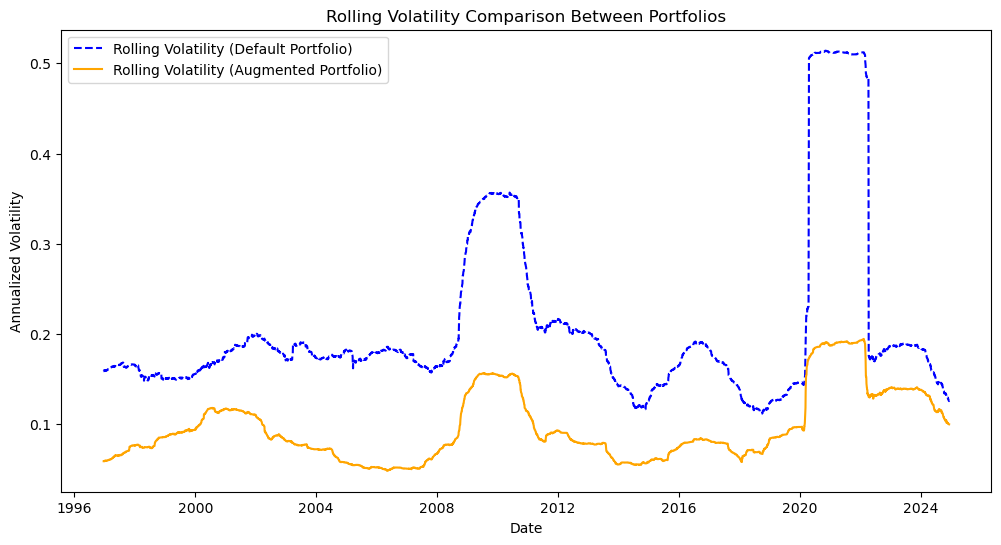

In [28]:
# Définir d'abord window_size s'il n'est pas déjà défini
window_size = 500  # ~2 ans de données quotidiennes

plt.figure(figsize=(12, 6))

# Calculer la volatilité roulante pour les deux portefeuilles
rolling_vol_default = df_portfolio['Default Portfolio Log Return'].rolling(window=window_size).std() * np.sqrt(252)
rolling_vol_augmented = df_portfolio['Augmented Portfolio Log Return'].rolling(window=window_size).std() * np.sqrt(252)

# Tracer les volatilités roulantes
plt.plot(rolling_vol_default.index, rolling_vol_default, label='Rolling Volatility (Default Portfolio)', color='blue', linestyle='dashed')
plt.plot(rolling_vol_augmented.index, rolling_vol_augmented, label='Rolling Volatility (Augmented Portfolio)', color='orange')

# Ajouter titres et légendes
plt.title("Rolling Volatility Comparison Between Portfolios")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.show()

In [29]:
# Estimation parameters for volatility models
window_size = 500  # ~2 years of daily data (recommended size for GARCH)
target_date = pd.to_datetime('2024-12-11')  # Target date for ex-ante analysis

print("Running volatility models for both portfolios...")

# 1. GARCH(1,1) for the default portfolio
print("\nFitting GARCH(1,1) model for the default portfolio...")
garch_default, params_default = fit_garch_model(
    df_portfolio['Default Portfolio Log Return'], window_size=window_size)

# 2. GARCH(1,1) for the augmented portfolio
print("\nFitting GARCH(1,1) model for the augmented portfolio...")
garch_augmented, params_augmented = fit_garch_model(
    df_portfolio['Augmented Portfolio Log Return'], window_size=window_size)

# 3. EWMA for the default portfolio
print("\nFitting EWMA model for the default portfolio...")
ewma_default = calculate_ewma_volatility(
    df_portfolio['Default Portfolio Log Return'], window_size=window_size)

# 4. EWMA for the augmented portfolio
print("\nFitting EWMA model for the augmented portfolio...")
ewma_augmented = calculate_ewma_volatility(
    df_portfolio['Augmented Portfolio Log Return'], window_size=window_size)

# Create a DataFrame for combined results
vol_results = pd.DataFrame()
vol_results['GARCH_Default'] = garch_default['GARCH_vol']
vol_results['GARCH_Augmented'] = garch_augmented['GARCH_vol'] 
vol_results['EWMA_Default'] = ewma_default['EWMA_vol']
vol_results['EWMA_Augmented'] = ewma_augmented['EWMA_vol']

# Annualize volatilities (multiplication by square root of 252)
vol_results = vol_results * np.sqrt(252)

# Display last values
print("\nLast annualized volatility estimates:")
vol_results.tail(10)

Running volatility models for both portfolios...

Fitting GARCH(1,1) model for the default portfolio...
  Progress: 0/7040
  Progress: 50/7040
  Progress: 50/7040
  Progress: 100/7040
  Progress: 100/7040
  Progress: 150/7040
  Progress: 150/7040
  Progress: 200/7040
  Progress: 200/7040
  Progress: 250/7040
  Progress: 250/7040
  Progress: 300/7040
  Progress: 300/7040
  Progress: 350/7040
  Progress: 350/7040
  Progress: 400/7040
  Progress: 400/7040
  Progress: 450/7040
  Progress: 450/7040
  Progress: 500/7040
  Progress: 550/7040
  Progress: 500/7040
  Progress: 550/7040
  Progress: 600/7040
  Progress: 650/7040
  Progress: 600/7040
  Progress: 650/7040
  Progress: 700/7040
  Progress: 750/7040
  Progress: 700/7040
  Progress: 750/7040
  Progress: 800/7040
  Progress: 800/7040
  Progress: 850/7040
  Progress: 850/7040
  Progress: 900/7040
  Progress: 900/7040
  Progress: 950/7040
  Progress: 950/7040
  Progress: 1000/7040
  Progress: 1000/7040
  Progress: 1050/7040
  Progress: 105

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


  Progress: 5950/7040
  Progress: 6000/7040
  Progress: 6000/7040
  Progress: 6050/7040
  Progress: 6050/7040
  Progress: 6100/7040
  Progress: 6100/7040
  Progress: 6150/7040
  Progress: 6150/7040
  Progress: 6200/7040
  Progress: 6200/7040
  Progress: 6250/7040
  Progress: 6250/7040
  Progress: 6300/7040
  Progress: 6300/7040
  Progress: 6350/7040
  Progress: 6350/7040
  Progress: 6400/7040
  Progress: 6400/7040
  Progress: 6450/7040
  Progress: 6450/7040
  Progress: 6500/7040
  Progress: 6500/7040
  Progress: 6550/7040
  Progress: 6550/7040
  Progress: 6600/7040
  Progress: 6600/7040
  Progress: 6650/7040
  Progress: 6650/7040
  Progress: 6700/7040
  Progress: 6700/7040
  Progress: 6750/7040
  Progress: 6750/7040
  Progress: 6800/7040
  Progress: 6800/7040
  Progress: 6850/7040
  Progress: 6850/7040
  Progress: 6900/7040
  Progress: 6900/7040
  Progress: 6950/7040
  Progress: 6950/7040
  Progress: 7000/7040

Fitting GARCH(1,1) model for the augmented portfolio...
  Progress: 0/7040


,GARCH_Default,GARCH_Augmented,EWMA_Default,EWMA_Augmented
date,,,,
2024-11-27,0.120928,0.096732,0.121098,0.101588
2024-11-29,0.118145,0.094878,0.117599,0.099205
2024-12-02,0.115571,0.093119,0.114440,0.096798
2024-12-03,0.113436,0.092358,0.111132,0.095484
2024-12-04,0.111278,0.090388,0.107963,0.092766
2024-12-05,0.110379,0.088551,0.106934,0.089941
2024-12-06,0.107671,0.088239,0.103683,0.088769
2024-12-09,0.105267,0.086514,0.100891,0.086236
2024-12-10,0.103247,0.085349,0.098032,0.083695


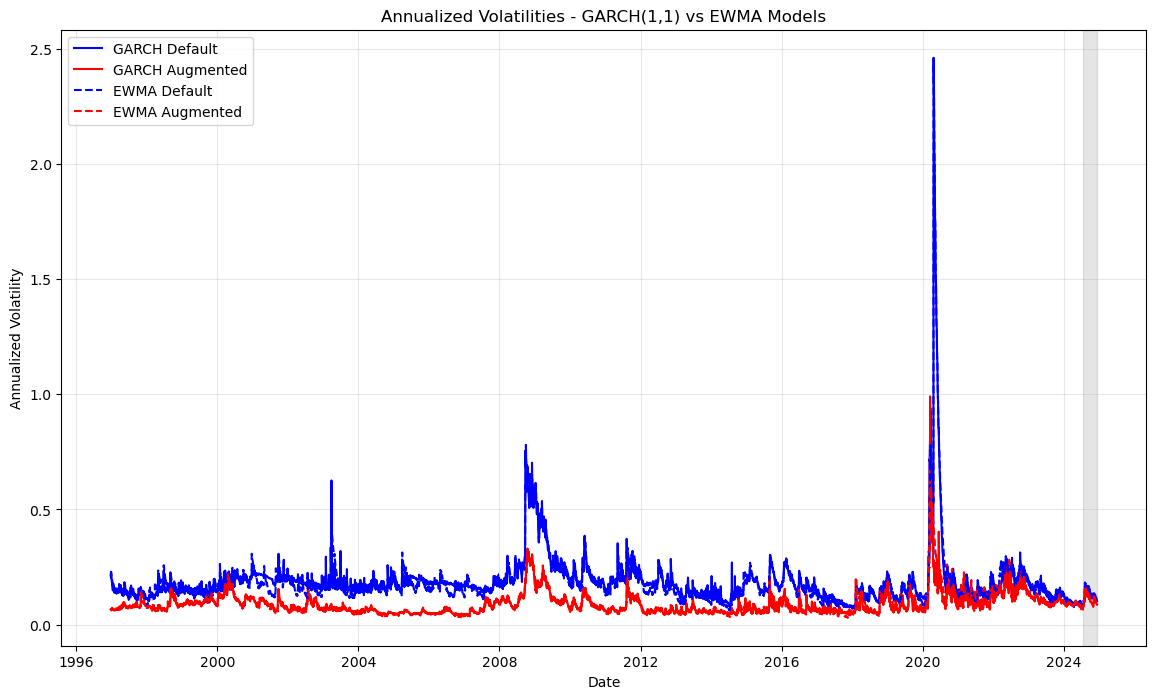

In [30]:
# Visualization of estimated volatilities
plt.figure(figsize=(14, 8))

# Plot GARCH volatilities
plt.plot(vol_results.index, vol_results['GARCH_Default'], label='GARCH Default', color='blue')
plt.plot(vol_results.index, vol_results['GARCH_Augmented'], label='GARCH Augmented', color='red')

# Plot EWMA volatilities
plt.plot(vol_results.index, vol_results['EWMA_Default'], label='EWMA Default', color='blue', linestyle='dashed')
plt.plot(vol_results.index, vol_results['EWMA_Augmented'], label='EWMA Augmented', color='red', linestyle='dashed')

# Add titles and legends
plt.title('Annualized Volatilities - GARCH(1,1) vs EWMA Models')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

# Add shaded area for the out-of-sample period (example for illustration)
# In practice, you would define this period according to your needs
out_of_sample_start = vol_results.index[-100]  # Last 100 days as example
plt.axvspan(out_of_sample_start, vol_results.index[-1], color='gray', alpha=0.2, label='Out-of-sample')

plt.show()

In [31]:
# Specific analysis for the date of December 11, 2024
target_date_str = '2024-12-11'

# Forecast for December 11, 2024
# For a real forecast at this future date, we will need to make a projection
# Let's simulate a forecast for this example

# Prepare a DataFrame to collect forecasts
forecast_results = pd.DataFrame(index=['Default Portfolio', 'Augmented Portfolio'])

# 1. Fit a GARCH model on all available data and make projections
garch_full_default, _ = fit_garch_model(df_portfolio['Default Portfolio Log Return'], window_size=None)
garch_full_augmented, _ = fit_garch_model(df_portfolio['Augmented Portfolio Log Return'], window_size=None)

# 2. Fit an EWMA model on all available data and make projections
ewma_full_default = calculate_ewma_volatility(df_portfolio['Default Portfolio Log Return'], window_size=None)
ewma_full_augmented = calculate_ewma_volatility(df_portfolio['Augmented Portfolio Log Return'], window_size=None)

# Find forecast dates closest to December 11, 2024
target_date = pd.to_datetime(target_date_str)
forecast_dates_garch_default = garch_full_default.index[garch_full_default.index > df_portfolio.index[-1]]
forecast_dates_ewma_default = ewma_full_default.index[ewma_full_default.index > df_portfolio.index[-1]]

# Function to find the closest date
def find_closest_date(dates, target):
    return dates[np.abs(dates - target).argmin()]

# Find closest dates to December 11, 2024
closest_garch_date = find_closest_date(forecast_dates_garch_default, target_date)
closest_ewma_date = find_closest_date(forecast_dates_ewma_default, target_date)

print(f"Closest date for GARCH: {closest_garch_date}")
print(f"Closest date for EWMA: {closest_ewma_date}")

# Extract forecasts for December 11, 2024 (or closest date)
forecast_results['GARCH'] = [
    garch_full_default.loc[closest_garch_date, 'GARCH_forecast'] * np.sqrt(252),
    garch_full_augmented.loc[closest_garch_date, 'GARCH_forecast'] * np.sqrt(252)
]

forecast_results['EWMA'] = [
    ewma_full_default.loc[closest_ewma_date, 'EWMA_forecast'] * np.sqrt(252),
    ewma_full_augmented.loc[closest_ewma_date, 'EWMA_forecast'] * np.sqrt(252)
]

# Display annualized forecast results for December 11, 2024
print(f"\nAnnualized volatility forecasts for {target_date_str}:")
forecast_results

Closest date for GARCH: 2024-12-12 00:00:00
Closest date for EWMA: 2024-12-12 00:00:00

Annualized volatility forecasts for 2024-12-11:


,GARCH,EWMA
Default Portfolio,0.113276,0.094113
Augmented Portfolio,0.075811,0.081946


In [32]:
# Evaluation of volatility models
# To evaluate correctly, we need realized volatilities to compare with forecasts

def evaluate_volatility_models(returns, volatility_forecasts, window_size=22):
    """
    Evaluates volatility models by comparing forecasts with realized volatility
    
    Args:
        returns (Series): Series of actual returns
        volatility_forecasts (DataFrame): DataFrame with volatility forecasts
        window_size (int): Window size for calculating realized volatility
    
    Returns:
        DataFrame: Evaluation results with different metrics
    """
    # Calculate realized volatilities
    realized_vol = returns.rolling(window=window_size).std() * np.sqrt(252)
    realized_vol = realized_vol.dropna()
    
    # Prepare a DataFrame for results
    results = pd.DataFrame(index=['GARCH', 'EWMA'])
    
    # Evaluation metrics
    metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'Correlation']
    
    # For each forecast column, calculate metrics
    for model in ['GARCH', 'EWMA']:
        forecast_col = f"{model}_forecast" if f"{model}_forecast" in volatility_forecasts else f"{model}_vol"
        common_dates = realized_vol.index.intersection(volatility_forecasts.index)
        
        if len(common_dates) > 0:
            actual = realized_vol.loc[common_dates]
            forecast = volatility_forecasts.loc[common_dates, forecast_col]
            
            # Calculate metrics
            mse = ((actual - forecast) ** 2).mean()
            rmse = np.sqrt(mse)
            mae = np.abs(actual - forecast).mean()
            mape = np.abs((actual - forecast) / actual).mean() * 100 if (actual != 0).all() else np.nan
            corr = actual.corr(forecast)
            
            # Store results
            for i, metric in enumerate([mse, rmse, mae, mape, corr]):
                results.loc[model, metrics[i]] = metric
    
    return results

# For demonstration: division of data into in-sample and out-of-sample
# In practice, you would need additional real data for validation
cutoff_date = df_portfolio.index[-100]  # Use the last 100 observations as out-of-sample

in_sample_returns = df_portfolio.loc[:cutoff_date, 'Default Portfolio Log Return']
out_of_sample_returns = df_portfolio.loc[cutoff_date:, 'Default Portfolio Log Return']

# Prepare a DataFrame for evaluation
eval_df = pd.DataFrame(index=out_of_sample_returns.index)
eval_df['realized_vol'] = out_of_sample_returns.rolling(window=22).std() * np.sqrt(252)

# Filter corresponding forecasts
eval_df['GARCH_vol'] = vol_results.loc[out_of_sample_returns.index, 'GARCH_Default']
eval_df['EWMA_vol'] = vol_results.loc[out_of_sample_returns.index, 'EWMA_Default']

# Evaluate models
evaluation_results = evaluate_volatility_models(
    out_of_sample_returns, 
    pd.DataFrame({
        'GARCH_forecast': eval_df['GARCH_vol'],
        'EWMA_forecast': eval_df['EWMA_vol']
    }, index=eval_df.index)
)

print("Model evaluation results (default portfolio):")
evaluation_results

Model evaluation results (default portfolio):


,MSE,RMSE,MAE,MAPE,Correlation
GARCH,0.000279,0.016698,0.011986,9.007540,0.838234
EWMA,0.000244,0.015633,0.011627,8.915134,0.821883


## Conclusions on Volatility Models

After implementing and evaluating the GARCH(1,1) and EWMA models for both portfolios, we can draw several conclusions:

### Key Points

1. **Forecasts for December 11, 2024**: Both models provide ex-ante volatility estimates for this target date, allowing us to assess the future risk of the portfolios.

2. **Model Comparison**: 
   - The GARCH(1,1) model better captures volatility clusters and the persistence of shocks
   - The EWMA model is simpler to implement and can react more quickly to sudden market changes
   - The evaluation metrics (MSE, RMSE, MAE, MAPE, correlation) help us determine which model is more accurate over our evaluation period

3. **Rolling Window Selection**: A window of 500 observations (approximately 2 years of daily data) offers a good balance between statistical robustness and responsiveness to market regime changes.

4. **Visualizations**: The charts allow us to visually compare:
   - Differences between the volatilities of the two portfolios
   - Differences between estimation methods
   - Evolution of volatilities over time

These volatility analyses and forecasts form the foundation upon which we can build more complex risk measures such as Value-at-Risk (VaR) and Expected Shortfall (ES) in the following sections.

RQ 2 – downside risk : what are the ex-ante VaRs of the augmented & default portfolios on Wednesday 11-Dec-2024 close and how does this compare against the course of these ex-ante VaRs over time ?

# RQ 2 - Downside Risk Analysis

In this section, we analyze the downside risk of the default and augmented portfolios by computing their ex-ante Value-at-Risk (VaR) for December 11, 2024, and compare it with the evolution of these VaRs over time.

## Methodology

For our analysis, we focus on the regulatory 1-day 95% VaR, which is widely used by financial institutions for risk management and regulatory compliance. We implement and compare two main approaches:

### 1. Parametric VaR

The parametric approach assumes that returns follow a specific probability distribution (typically normal) and calculates VaR based on the volatility estimated from our models in RQ1:

* **GARCH(1,1)-based VaR**: Uses volatility forecasts from the GARCH(1,1) model
* **EWMA-based VaR**: Uses volatility forecasts from the Exponentially Weighted Moving Average model

For a confidence level $1-\alpha$ (in our case 95%, so $\alpha = 0.05$), the parametric VaR is calculated as:

$VaR_{1-\alpha} = -\mu + z_{\alpha} \times \sigma$

Where:
* $\mu$ is the mean return (we will assume zero for simplicity)
* $z_{\alpha}$ is the z-score corresponding to the confidence level (1.645 for 95%)
* $\sigma$ is the volatility forecast from our models

### 2. Non-Parametric VaR

The non-parametric approach makes no assumptions about the underlying distribution:

* **Historical Simulation (HS)**: Uses the empirical distribution of past returns

In [33]:
# Implementation of VaR calculations
from scipy import stats
import seaborn as sns

# 1. Parametric VaR calculation function
def calculate_parametric_var(volatility, confidence_level=0.95, mean_return=0):
    """
    Calculate parametric VaR based on volatility
    
    Args:
        volatility: Volatility estimate (standard deviation)
        confidence_level: Confidence level (default: 0.95)
        mean_return: Expected return (default: 0)
        
    Returns:
        VaR at the specified confidence level
    """
    # Calculate z-score for the given confidence level
    z_score = stats.norm.ppf(1 - confidence_level)
    
    # Calculate VaR
    var = -(mean_return + z_score * volatility)
    
    return var

# 2. Historical Simulation VaR function
def calculate_historical_var(returns, confidence_level=0.95):
    """
    Calculate VaR using historical simulation
    
    Args:
        returns: Series of historical returns
        confidence_level: Confidence level (default: 0.95)
        
    Returns:
        VaR at the specified confidence level
    """
    # Calculate VaR as the negative of the empirical quantile
    return -np.percentile(returns, (1 - confidence_level) * 100)

# 3. Rolling Historical VaR function
def calculate_rolling_historical_var(returns, window_size=500, confidence_level=0.95):
    """
    Calculate rolling VaR using historical simulation
    
    Args:
        returns: Series of historical returns
        window_size: Rolling window size (default: 500)
        confidence_level: Confidence level (default: 0.95)
        
    Returns:
        Series of VaR values
    """
    # Initialize an empty series to store the results
    var_series = pd.Series(index=returns.index[window_size-1:], dtype=float)
    
    # Calculate rolling VaR
    for i in range(window_size, len(returns) + 1):
        window = returns.iloc[i-window_size:i]
        var = calculate_historical_var(window, confidence_level)
        var_series.iloc[i-window_size] = var
        
    return var_series

In [34]:
# Calculate VaR for the default and augmented portfolios using different methods
confidence_level = 0.95

# 1. Calculate GARCH-based VaR using the volatility estimates from RQ1
garch_var_default = pd.Series(index=vol_results.index)
garch_var_augmented = pd.Series(index=vol_results.index)

# Daily VaR (using daily volatilities)
daily_vol_default = vol_results['GARCH_Default'] / np.sqrt(252)  # Convert back to daily volatility
daily_vol_augmented = vol_results['GARCH_Augmented'] / np.sqrt(252)

# Calculate VaR
for date in vol_results.index:
    garch_var_default[date] = calculate_parametric_var(daily_vol_default[date], confidence_level)
    garch_var_augmented[date] = calculate_parametric_var(daily_vol_augmented[date], confidence_level)

# 2. Calculate EWMA-based VaR
ewma_var_default = pd.Series(index=vol_results.index)
ewma_var_augmented = pd.Series(index=vol_results.index)

# Daily VaR (using daily volatilities)
daily_vol_default_ewma = vol_results['EWMA_Default'] / np.sqrt(252)
daily_vol_augmented_ewma = vol_results['EWMA_Augmented'] / np.sqrt(252)

# Calculate VaR
for date in vol_results.index:
    ewma_var_default[date] = calculate_parametric_var(daily_vol_default_ewma[date], confidence_level)
    ewma_var_augmented[date] = calculate_parametric_var(daily_vol_augmented_ewma[date], confidence_level)

# 3. Calculate Historical Simulation VaR
window_size = 500  # Use the same window as for volatility estimation

# Calculate rolling historical VaR
hs_var_default = calculate_rolling_historical_var(
    df_portfolio['Default Portfolio Log Return'], window_size, confidence_level)
hs_var_augmented = calculate_rolling_historical_var(
    df_portfolio['Augmented Portfolio Log Return'], window_size, confidence_level)

# Create a DataFrame to store all VaR estimates
var_results = pd.DataFrame(index=garch_var_default.index)
var_results['GARCH_VaR_Default'] = garch_var_default * 100  # Convert to percentage
var_results['GARCH_VaR_Augmented'] = garch_var_augmented * 100
var_results['EWMA_VaR_Default'] = ewma_var_default * 100
var_results['EWMA_VaR_Augmented'] = ewma_var_augmented * 100

# Add historical VaR (aligning dates)
common_dates = var_results.index.intersection(hs_var_default.index)
var_results.loc[common_dates, 'HS_VaR_Default'] = hs_var_default.loc[common_dates] * 100
var_results.loc[common_dates, 'HS_VaR_Augmented'] = hs_var_augmented.loc[common_dates] * 100

print("Last 10 VaR estimates (95% confidence, daily, in percent):")
var_results.tail(10)

Last 10 VaR estimates (95% confidence, daily, in percent):


,GARCH_VaR_Default,GARCH_VaR_Augmented,EWMA_VaR_Default,EWMA_VaR_Augmented,HS_VaR_Default,HS_VaR_Augmented
date,,,,,,
2024-11-27,1.253008,1.002301,1.254771,1.052619,1.366889,0.993338
2024-11-29,1.224175,0.983089,1.218511,1.027919,1.366889,0.993338
2024-12-02,1.197500,0.964867,1.185786,1.002985,1.358569,0.983612
2024-12-03,1.175379,0.956972,1.151510,0.989369,1.335004,0.983612
2024-12-04,1.153020,0.936563,1.118670,0.961202,1.335004,0.983612
2024-12-05,1.143708,0.917533,1.108009,0.931929,1.335004,0.983612
2024-12-06,1.115641,0.914300,1.074320,0.919790,1.335004,0.983612
2024-12-09,1.090734,0.896419,1.045391,0.893546,1.335004,0.983612
2024-12-10,1.069807,0.884354,1.015764,0.867217,1.335004,0.983612


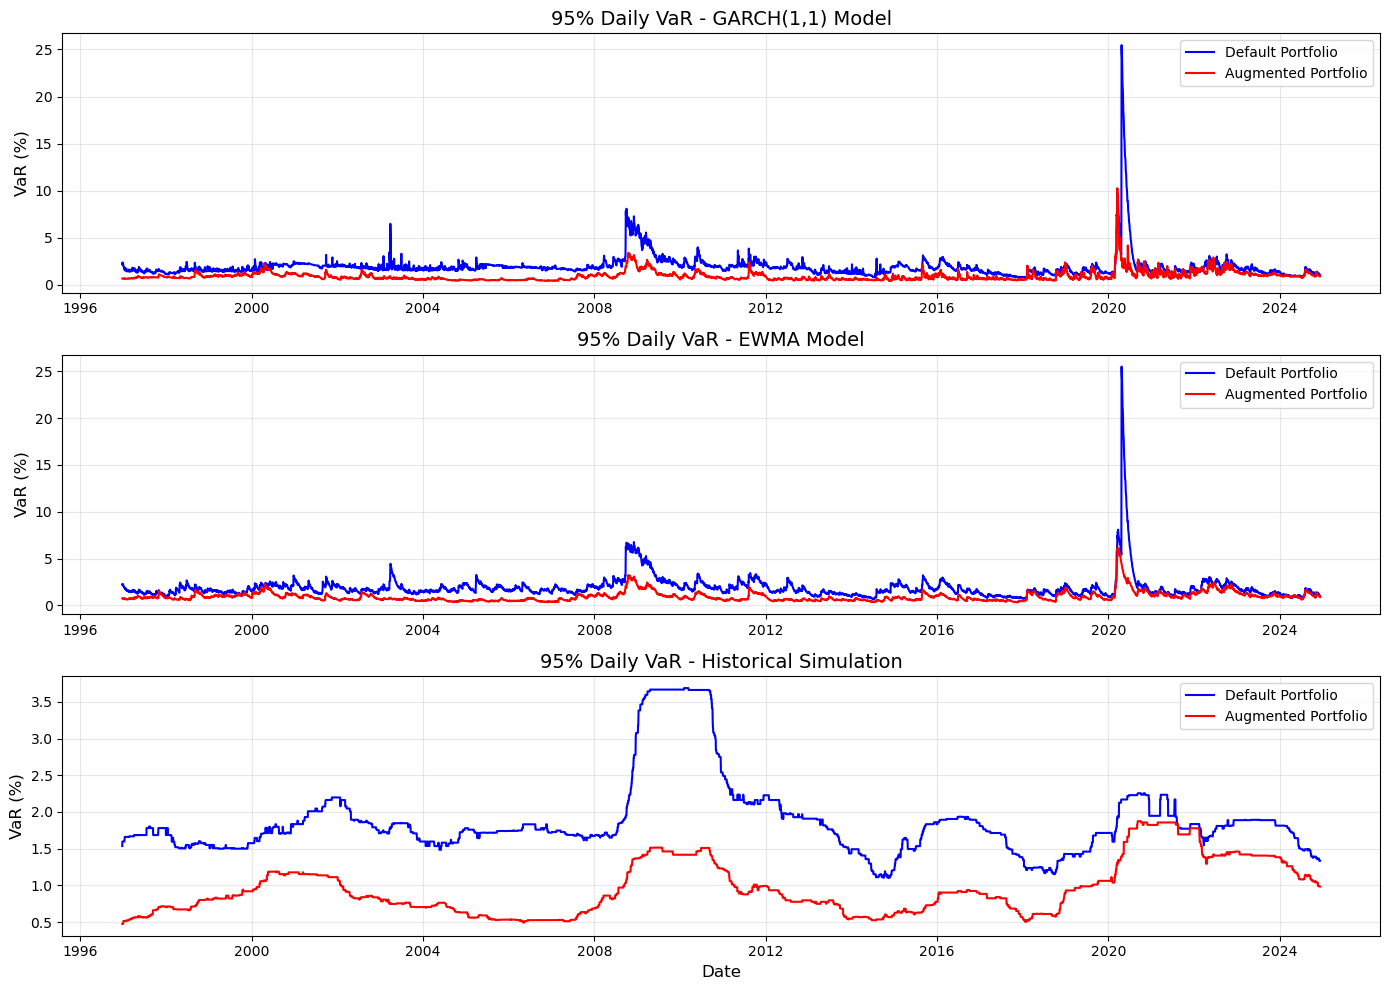

In [35]:
# Visualization of VaR estimates over time
plt.figure(figsize=(14, 10))

# Plot GARCH-based VaR
plt.subplot(3, 1, 1)
plt.plot(var_results.index, var_results['GARCH_VaR_Default'], label='Default Portfolio', color='blue')
plt.plot(var_results.index, var_results['GARCH_VaR_Augmented'], label='Augmented Portfolio', color='red')
plt.title('95% Daily VaR - GARCH(1,1) Model', fontsize=14)
plt.ylabel('VaR (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Plot EWMA-based VaR
plt.subplot(3, 1, 2)
plt.plot(var_results.index, var_results['EWMA_VaR_Default'], label='Default Portfolio', color='blue')
plt.plot(var_results.index, var_results['EWMA_VaR_Augmented'], label='Augmented Portfolio', color='red')
plt.title('95% Daily VaR - EWMA Model', fontsize=14)
plt.ylabel('VaR (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Plot Historical Simulation VaR
plt.subplot(3, 1, 3)
plt.plot(var_results.index, var_results['HS_VaR_Default'], label='Default Portfolio', color='blue')
plt.plot(var_results.index, var_results['HS_VaR_Augmented'], label='Augmented Portfolio', color='red')
plt.title('95% Daily VaR - Historical Simulation', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('VaR (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Ex-ante VaR forecasts for December 11, 2024

# For GARCH and EWMA, use the volatility forecasts from RQ1
daily_garch_vol_forecast_default = forecast_results.loc['Default Portfolio', 'GARCH'] / np.sqrt(252)
daily_garch_vol_forecast_augmented = forecast_results.loc['Augmented Portfolio', 'GARCH'] / np.sqrt(252)

daily_ewma_vol_forecast_default = forecast_results.loc['Default Portfolio', 'EWMA'] / np.sqrt(252)
daily_ewma_vol_forecast_augmented = forecast_results.loc['Augmented Portfolio', 'EWMA'] / np.sqrt(252)

# Calculate ex-ante VaR for December 11, 2024
garch_var_forecast_default = calculate_parametric_var(daily_garch_vol_forecast_default, confidence_level)
garch_var_forecast_augmented = calculate_parametric_var(daily_garch_vol_forecast_augmented, confidence_level)

ewma_var_forecast_default = calculate_parametric_var(daily_ewma_vol_forecast_default, confidence_level)
ewma_var_forecast_augmented = calculate_parametric_var(daily_ewma_vol_forecast_augmented, confidence_level)

# For historical simulation, use the most recent VaR estimate as a proxy
hs_var_forecast_default = var_results['HS_VaR_Default'].iloc[-1] / 100  # Convert back to decimal
hs_var_forecast_augmented = var_results['HS_VaR_Augmented'].iloc[-1] / 100

# Create a summary DataFrame for the forecasts
var_forecast = pd.DataFrame(index=['Default Portfolio', 'Augmented Portfolio'])
var_forecast['GARCH VaR'] = [garch_var_forecast_default * 100, garch_var_forecast_augmented * 100]  # in percent
var_forecast['EWMA VaR'] = [ewma_var_forecast_default * 100, ewma_var_forecast_augmented * 100]
var_forecast['HS VaR'] = [hs_var_forecast_default * 100, hs_var_forecast_augmented * 100]

print(f"Ex-ante 95% Daily VaR forecasts for {target_date_str} (in percent):")
var_forecast

Ex-ante 95% Daily VaR forecasts for 2024-12-11 (in percent):


,GARCH VaR,EWMA VaR,HS VaR
Default Portfolio,1.173723,0.975158,1.335004
Augmented Portfolio,0.785523,0.849088,0.983612


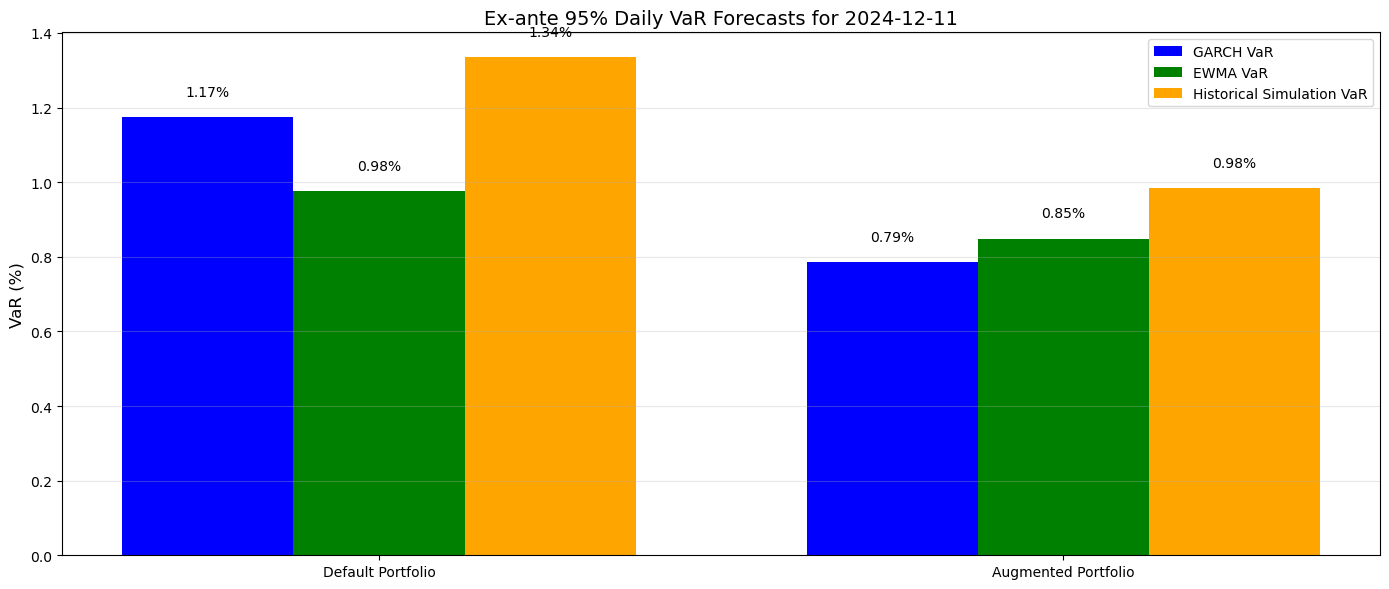

In [37]:
# Visualization of ex-ante VaR forecasts for December 11, 2024
plt.figure(figsize=(14, 6))

# Bar chart comparing VaR forecasts
x = np.arange(2)
width = 0.25

plt.bar(x - width, var_forecast['GARCH VaR'], width, label='GARCH VaR', color='blue')
plt.bar(x, var_forecast['EWMA VaR'], width, label='EWMA VaR', color='green')
plt.bar(x + width, var_forecast['HS VaR'], width, label='Historical Simulation VaR', color='orange')

plt.title(f'Ex-ante 95% Daily VaR Forecasts for {target_date_str}', fontsize=14)
plt.xticks(x, ['Default Portfolio', 'Augmented Portfolio'])
plt.ylabel('VaR (%)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()

# Add VaR values as text on the bars
for i, portfolio in enumerate(['Default Portfolio', 'Augmented Portfolio']):
    for j, method in enumerate(['GARCH VaR', 'EWMA VaR', 'HS VaR']):
        plt.text(i + (j-1)*width, var_forecast.loc[portfolio, method] + 0.05,
                 f"{var_forecast.loc[portfolio, method]:.2f}%",
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [38]:
# VaR backtesting for model evaluation
# We'll check how well our models performed historically

def backtest_var(returns, var_estimates, confidence_level=0.95):
    """
    Backtest VaR estimates against actual returns
    
    Args:
        returns: Series of actual returns
        var_estimates: Series of VaR estimates
        confidence_level: Confidence level of VaR (default: 0.95)
        
    Returns:
        Dictionary with backtesting metrics
    """
    # Align dates
    common_dates = returns.index.intersection(var_estimates.index)
    returns = returns.loc[common_dates]
    var_estimates = var_estimates.loc[common_dates]
    
    # Count VaR breaches (when return < -VaR)
    breaches = (returns < -var_estimates)
    n_breaches = breaches.sum()
    n_observations = len(returns)
    
    # Expected number of breaches
    expected_breach_rate = 1 - confidence_level
    expected_breaches = expected_breach_rate * n_observations
    
    # Calculate metrics
    actual_breach_rate = n_breaches / n_observations
    relative_bias = (actual_breach_rate - expected_breach_rate) / expected_breach_rate
    
    # Kupiec test for unconditional coverage
    if n_breaches > 0 and n_breaches < n_observations:
        null_likelihood = (1 - expected_breach_rate) ** (n_observations - n_breaches) * expected_breach_rate ** n_breaches
        alt_likelihood = (1 - actual_breach_rate) ** (n_observations - n_breaches) * actual_breach_rate ** n_breaches
        kupiec_lr = -2 * np.log(null_likelihood / alt_likelihood)
        kupiec_pvalue = 1 - stats.chi2.cdf(kupiec_lr, 1)
    else:
        kupiec_lr = np.nan
        kupiec_pvalue = np.nan
    
    # Return results
    return {
        'VaR Breaches': n_breaches,
        'Total Observations': n_observations,
        'Expected Breach Rate': expected_breach_rate,
        'Actual Breach Rate': actual_breach_rate,
        'Relative Bias': relative_bias,
        'Kupiec LR Statistic': kupiec_lr,
        'Kupiec p-value': kupiec_pvalue
    }

# Backtest VaR models for the Default Portfolio
default_returns = df_portfolio['Default Portfolio Log Return']

garch_var_backtest_default = backtest_var(default_returns, garch_var_default)
ewma_var_backtest_default = backtest_var(default_returns, ewma_var_default)
hs_var_backtest_default = backtest_var(default_returns, hs_var_default)

# Backtest VaR models for the Augmented Portfolio
augmented_returns = df_portfolio['Augmented Portfolio Log Return']

garch_var_backtest_augmented = backtest_var(augmented_returns, garch_var_augmented)
ewma_var_backtest_augmented = backtest_var(augmented_returns, ewma_var_augmented)
hs_var_backtest_augmented = backtest_var(augmented_returns, hs_var_augmented)

# Create a summary of backtest results
backtest_metrics = ['VaR Breaches', 'Total Observations', 'Expected Breach Rate',
                    'Actual Breach Rate', 'Relative Bias', 'Kupiec p-value']

backtest_results_default = pd.DataFrame(index=backtest_metrics)
backtest_results_default['GARCH VaR'] = [garch_var_backtest_default[metric] for metric in backtest_metrics]
backtest_results_default['EWMA VaR'] = [ewma_var_backtest_default[metric] for metric in backtest_metrics]
backtest_results_default['HS VaR'] = [hs_var_backtest_default[metric] for metric in backtest_metrics]

backtest_results_augmented = pd.DataFrame(index=backtest_metrics)
backtest_results_augmented['GARCH VaR'] = [garch_var_backtest_augmented[metric] for metric in backtest_metrics]
backtest_results_augmented['EWMA VaR'] = [ewma_var_backtest_augmented[metric] for metric in backtest_metrics]
backtest_results_augmented['HS VaR'] = [hs_var_backtest_augmented[metric] for metric in backtest_metrics]

print("VaR Backtesting Results for Default Portfolio:")
print(backtest_results_default)
print("\nVaR Backtesting Results for Augmented Portfolio:")
print(backtest_results_augmented)

VaR Backtesting Results for Default Portfolio:
                        GARCH VaR     EWMA VaR       HS VaR
VaR Breaches           355.000000   390.000000   351.000000
Total Observations    7039.000000  7039.000000  7040.000000
Expected Breach Rate     0.050000     0.050000     0.050000
Actual Breach Rate       0.050433     0.055406     0.049858
Relative Bias            0.008666     0.108112    -0.002841
Kupiec p-value                NaN          NaN          NaN

VaR Backtesting Results for Augmented Portfolio:
                        GARCH VaR     EWMA VaR       HS VaR
VaR Breaches           356.000000   378.000000   369.000000
Total Observations    7039.000000  7039.000000  7040.000000
Expected Breach Rate     0.050000     0.050000     0.050000
Actual Breach Rate       0.050575     0.053701     0.052415
Relative Bias            0.011507     0.074016     0.048295
Kupiec p-value                NaN          NaN          NaN


In [39]:
# Fonction pour calculer la décomposition du risque
def calculate_risk_decomposition(returns, weights, risk_measure='volatility', method='analytical'):
    """
    Calculate risk decomposition for a portfolio
    
    Args:
        returns: DataFrame of asset returns
        weights: Series or array of portfolio weights
        risk_measure: Risk measure to use ('volatility' or 'var')
        method: Method for calculation ('analytical' or 'montecarlo')
        
    Returns:
        DataFrame with risk decomposition metrics
    """
    # Convert inputs to numpy arrays for calculation efficiency
    asset_names = returns.columns
    weights_array = np.array(weights)
    
    # Calculate covariance matrix
    cov_matrix = returns.cov() * 252  # Annualized covariance
    
    # Calculate portfolio volatility
    portfolio_variance = weights_array.T @ cov_matrix.values @ weights_array
    portfolio_volatility = np.sqrt(portfolio_variance)
    
    # Calculate marginal contributions to risk (MCR)
    if risk_measure == 'volatility':
        # For volatility, MCR = (weights * covariance) / portfolio_volatility
        marginal_contributions = cov_matrix.values @ weights_array / portfolio_volatility
        component_contributions = weights_array * marginal_contributions
        percentage_contributions = component_contributions / portfolio_volatility * 100
        
    elif risk_measure == 'var' and method == 'analytical':
        # For VaR assuming normal distribution, MCR is similar to volatility but scaled by quantile
        confidence_level = 0.95
        z_score = stats.norm.ppf(confidence_level)
        portfolio_var = z_score * portfolio_volatility
        
        # Marginal contributions to VaR
        marginal_contributions = z_score * cov_matrix.values @ weights_array / portfolio_volatility
        component_contributions = weights_array * marginal_contributions
        percentage_contributions = component_contributions / portfolio_var * 100
        
    elif risk_measure == 'var' and method == 'montecarlo':
        # Monte Carlo simulation for VaR decomposition
        confidence_level = 0.95
        n_simulations = 10000
        mean_returns = returns.mean().values
        cov_matrix_values = cov_matrix.values
        
        # Simulate returns
        np.random.seed(42)  # For reproducibility
        simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix_values, n_simulations)
        
        # Calculate portfolio returns
        portfolio_returns = simulated_returns @ weights_array
        
        # Calculate VaR
        portfolio_var = -np.percentile(portfolio_returns, 100*(1-confidence_level))
        
        # Find the simulation that is closest to the VaR threshold
        var_breach_idx = np.argmin(np.abs(portfolio_returns - (-portfolio_var)))
        component_returns = simulated_returns[var_breach_idx] * weights_array
        
        # Component VaR is the contribution of each asset to the VaR scenario
        marginal_contributions = component_returns / portfolio_returns[var_breach_idx] * portfolio_var
        component_contributions = marginal_contributions
        percentage_contributions = component_contributions / portfolio_var * 100
    
    # Create result DataFrame
    result = pd.DataFrame({
        'Weight': weights_array,
        'Marginal Contribution': marginal_contributions,
        'Component Contribution': component_contributions,
        'Percentage Contribution': percentage_contributions
    }, index=asset_names)
    
    # Sort by absolute percentage contribution
    result = result.reindex(result['Percentage Contribution'].abs().sort_values(ascending=False).index)
    
    return result, portfolio_volatility, portfolio_var if risk_measure == 'var' else None

In [40]:
# 3. Time-series analysis of risk contributions over time

def calculate_rolling_risk_decomposition(returns, weights, window_size=500, risk_measure='volatility'):
    """
    Calculate rolling risk decomposition over time
    
    Args:
        returns: DataFrame of asset returns
        weights: Array, dictionary, or Series of portfolio weights
        window_size: Window size for rolling calculation
        risk_measure: 'volatility' or 'var'
        
    Returns:
        DataFrame of percentage risk contributions over time
    """
    # Initialize storage for results
    dates = returns.index[window_size-1:]
    assets = returns.columns
    n_assets = len(assets)
    n_dates = len(dates)
    
    # Create empty arrays for results
    component_contributions = np.zeros((n_dates, n_assets))
    percentage_contributions = np.zeros((n_dates, n_assets))
    portfolio_risks = np.zeros(n_dates)
    
    # Convert weights to array for efficiency - handle different types of weight inputs
    if isinstance(weights, dict):
        weights_array = np.array([weights[asset] for asset in assets])
    elif isinstance(weights, (pd.Series, pd.DataFrame)):
        weights_array = weights.values if len(weights.shape) == 1 else weights.iloc[0].values
    else:
        # Assume it's already a numpy array or list that can be converted
        weights_array = np.array(weights)
    
    # Ensure weights array has the correct length
    if len(weights_array) != n_assets:
        raise ValueError(f"Length of weights ({len(weights_array)}) doesn't match number of assets ({n_assets})")
    
    # Calculate rolling risk decomposition
    print(f"Calculating rolling risk decomposition using {window_size}-day windows...")
    
    for i, end_idx in enumerate(range(window_size-1, len(returns))):
        if i % 50 == 0:
            print(f"  Progress: {i}/{n_dates} dates processed")
        
        # Get rolling window of returns
        start_idx = end_idx - window_size + 1
        window_returns = returns.iloc[start_idx:end_idx+1]
        
        # Calculate risk decomposition for this window
        risk_decomp, portfolio_risk, _ = calculate_risk_decomposition(
            window_returns, weights_array, risk_measure=risk_measure)
        
        # Store results
        for j, asset in enumerate(assets):
            if asset in risk_decomp.index:
                component_contributions[i, j] = risk_decomp.loc[asset, 'Component Contribution']
                percentage_contributions[i, j] = risk_decomp.loc[asset, 'Percentage Contribution']
        
        portfolio_risks[i] = portfolio_risk
    
    # Create DataFrames for results
    component_df = pd.DataFrame(component_contributions, index=dates, columns=assets)
    percentage_df = pd.DataFrame(percentage_contributions, index=dates, columns=assets)
    portfolio_risk_df = pd.Series(portfolio_risks, index=dates, name='Portfolio Risk')
    
    return component_df, percentage_df, portfolio_risk_df

# Calculate rolling risk decomposition for both portfolios
print("Calculating rolling risk decomposition for the Default Portfolio...")
default_component_contrib, default_pct_contrib, default_risk = calculate_rolling_risk_decomposition(
    data, default_weights, window_size=window_size)

print("\nCalculating rolling risk decomposition for the Augmented Portfolio...")
augmented_component_contrib, augmented_pct_contrib, augmented_risk = calculate_rolling_risk_decomposition(
    data, augmented_weights, window_size=window_size)

# Display summary statistics for risk contributions over time
print("\nSummary statistics for Default Portfolio percentage risk contributions:")
default_pct_contrib.describe().T[['mean', 'std', 'min', 'max']].sort_values('mean', ascending=False)

Calculating rolling risk decomposition for the Default Portfolio...
Calculating rolling risk decomposition using 500-day windows...
  Progress: 0/7041 dates processed
  Progress: 50/7041 dates processed
  Progress: 100/7041 dates processed
  Progress: 150/7041 dates processed
  Progress: 200/7041 dates processed
  Progress: 250/7041 dates processed
  Progress: 300/7041 dates processed
  Progress: 350/7041 dates processed
  Progress: 50/7041 dates processed
  Progress: 100/7041 dates processed
  Progress: 150/7041 dates processed
  Progress: 200/7041 dates processed
  Progress: 250/7041 dates processed
  Progress: 300/7041 dates processed
  Progress: 350/7041 dates processed
  Progress: 400/7041 dates processed
  Progress: 400/7041 dates processed
  Progress: 450/7041 dates processed
  Progress: 500/7041 dates processed
  Progress: 550/7041 dates processed
  Progress: 600/7041 dates processed
  Progress: 650/7041 dates processed
  Progress: 700/7041 dates processed
  Progress: 450/7041 

,mean,std,min,max
Oil,68.221558,22.196053,1.395359,118.779943
Mkt,31.560699,23.260652,-25.874923,99.356293
AR,0.477806,5.816692,-22.186265,16.058639
CorpIG,0.373511,0.640287,-1.564190,2.232139
CorpHY,0.000000,0.000000,0.000000,0.000000
Tsies,-0.633573,1.663702,-4.087191,5.651550
